Importing necessary libraries.

In [1]:
import json
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tqdm import tqdm
from tensorflow.keras.models import load_model
import imutils
import cv2, os, re
from imutils.object_detection import non_max_suppression

Extracting the dataset in a folder on Google drive which is mounted on this Colab notebook.

In [ ]:
!unzip "/content/drive/MyDrive/ShipDetection.zip" -d "/content/drive/My Drive/"

Archive:  /content/drive/MyDrive/ShipDetection.zip
replace /content/drive/My Drive/ShipDetection/shipsnet.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


 Loading the dataset json file.

In [2]:
f = open(r'/content/drive/MyDrive/ShipDetection/shipsnet.json')
dataset = json.load(f)
f.close()

Converting the data into Numpy arrays and seperating it into input data and label.

In [3]:
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')
input_data.shape

(4000, 19200)

Reshaping the imput data.

In [4]:
n_spectrum = 3 # the number of color chanels: RGB 
width = 80
height = 80
X = input_data.reshape([-1, n_spectrum, width, height])
X[0].shape

pic = X[3]
red_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectrum = pic[2]

Showing colour map for each of the 3 channels

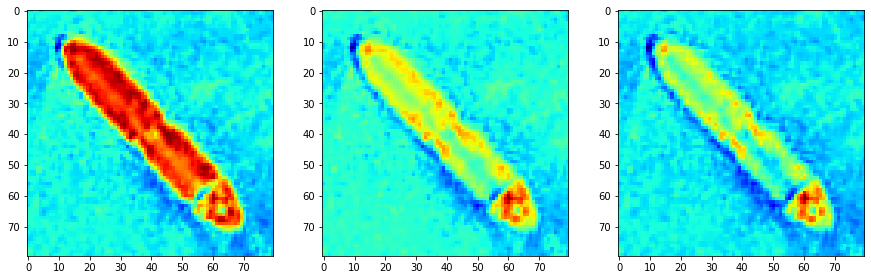

In [5]:
plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')
plt.subplot(1, 3, 1)
plt.imshow(red_spectrum)
plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)
plt.subplot(1, 3, 3)
plt.imshow(blue_spectrum)

Exploratory Analysis of Dataset.

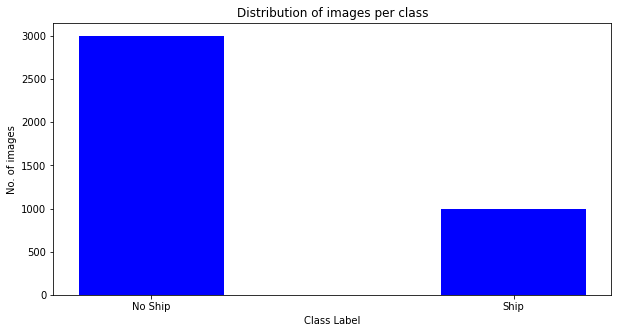

In [6]:
a,b = np.unique(output_data, return_counts= True)
fig = plt.figure(figsize = (10, 5))
ship= b[0]
no_ship=b[1]
plt.bar(['No Ship','Ship'], b, color ='blue',width = 0.4)
plt.xlabel("Class Label")
plt.ylabel("No. of images")
plt.title("Distribution of images per class")
plt.show()

We can see in the above bar plot that dataset is imbalanced.
Below balancing the data, we'll see a sample image.

(80, 80, 3)


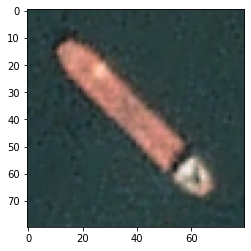

In [7]:
X=X.transpose([0,2,3,1])
print(X[5].shape)
sample_pic = X[5]
plt.imshow(X[5])

We are flipping the images in the "SHIP" class left to right and top to bottom, to balance out the dataset.
Below is an example of flipped image which was shown above.

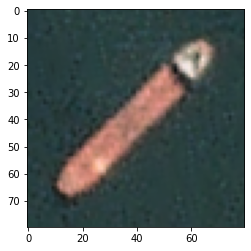

In [8]:
flip = np.flipud(X[5])
plt.imshow(flip)

Below we are artificially creating data to balance out the dataset. This process is called Data Augmentation.

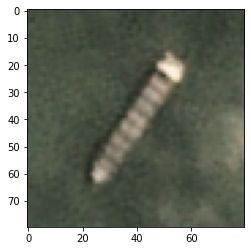

In [9]:
aug_images, aug_labels= [],[]
for i in range(len(X)):
  if output_data[i]==1:
    aug_images.append(np.flipud(X[i]))
    aug_labels.append(1)
    aug_images.append(np.fliplr(X[i]))
    aug_labels.append(1)


aug_images = np.array(aug_images).astype('uint8')
aug_labels = np.array(aug_labels).astype('uint8')

plt.imshow(aug_images[2])

Merging the augmented data which we created with original dataset.

In [10]:
X = np.concatenate([X, aug_images])
output_data = np.concatenate([output_data, aug_labels])
X.shape, output_data.shape

((6000, 80, 80, 3), (6000,))

Below we can see that the dataset is balanced now and both the classes have equal number of images.

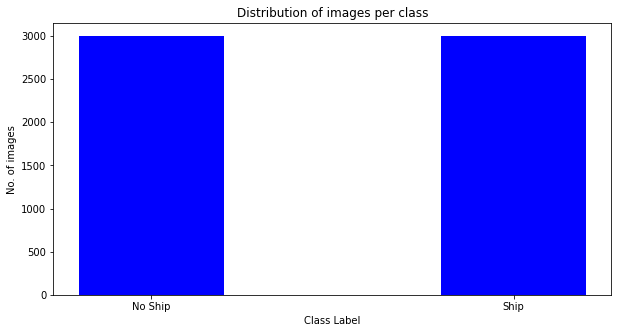

In [11]:
a,b = np.unique(output_data, return_counts= True)
fig = plt.figure(figsize = (10, 5))
ship= b[0]
no_ship=b[1]
plt.bar(['No Ship','Ship'], b, color ='blue',width = 0.4)
plt.xlabel("Class Label")
plt.ylabel("No. of images")
plt.title("Distribution of images per class")
plt.show()

Converting the labels of our dataset into categorical form for training the model.

In [12]:
labels = to_categorical(output_data, 2)
images = X

Below we are shuffing our dataset in order to prevent any correlation between the images next to each other. It is a good practice to do in order to make our model more robust.

In [13]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

Now we are splitting our dataset into train, validation and test sets.

In [14]:
images = images/255
total_count = len(images)
total_count

train = int(0.65*total_count)
val = int(0.2*total_count)
test = int(0.15*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, val_images.shape, test_images.shape

((3900, 80, 80, 3), (1200, 80, 80, 3), (900, 80, 80, 3))

We are using a standard CNN architecture, which was inspired from VGG16 model.
Below are the components of our CNN:

*   Conv2D - This is a 2 dimensional convolutional layer, the number of filters 
decide what the convolutional layer learns. Greater the number of filters, greater the amount of information obtained.
*   MaxPooling2D - This reduces the spatial dimensions of the feature map produced by the convolutional layer without losing any range information. This allows a model to become slightly more robust

*   Dropout - This removes a user-defined percentage of links between neurons of consecutive layers. This allows the model to be robust. It can be used in both fully convolutional layers and fully connected layers.
*  Padding- This pads the feature map/input image with zeros allowing border features to stay.


*   BatchNormalization - This layer normalises the values present in the hidden part of the neural network. This is similar to MinMax/Standard scaling applied in machine learning algorithms











We are making a Sequential model, which means we can easily add next layer to our CNN. It's drawback in comparison to Functional implementation is that functional model offers more flexibility because we don’t need to attach layers in sequential order.

The input for our CNN will be our train images, and model's aim is to classify whether the image has a ship or not.

In [15]:
np.random.seed(42)
# network design
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 80, 80, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 40, 40, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 40, 40, 32)       1

We are using Adam optimizer to compile our model and Loss function as *Binary Crossentropy* since we have only 2 classes. If we would have had more classes, we would have choses *Categorical Crossentropy*.

We will train the model for 50 epochs with each batch size of 16.

In [16]:
# optimization setup
optim = Adam(lr=1e-3)
model.compile(optimizer=optim,loss='binary_crossentropy',metrics=['accuracy'])
  # training
history = model.fit(
      train_images, 
      train_labels,
      steps_per_epoch=len(train_images)//16,
      batch_size=16,
      epochs=50,
      validation_data=(val_images,val_labels),
      validation_steps=len(val_images)//16,
      shuffle=True,
      verbose=2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
243/243 - 15s - loss: 0.2822 - accuracy: 0.8796 - val_loss: 0.7252 - val_accuracy: 0.5508 - 15s/epoch - 60ms/step
Epoch 2/50
243/243 - 3s - loss: 0.1397 - accuracy: 0.9549 - val_loss: 0.2244 - val_accuracy: 0.9083 - 3s/epoch - 11ms/step
Epoch 3/50
243/243 - 2s - loss: 0.0901 - accuracy: 0.9712 - val_loss: 0.0679 - val_accuracy: 0.9700 - 2s/epoch - 10ms/step
Epoch 4/50
243/243 - 2s - loss: 0.0820 - accuracy: 0.9706 - val_loss: 0.1204 - val_accuracy: 0.9567 - 2s/epoch - 10ms/step
Epoch 5/50
243/243 - 2s - loss: 0.0688 - accuracy: 0.9786 - val_loss: 0.0565 - val_accuracy: 0.9758 - 2s/epoch - 10ms/step
Epoch 6/50
243/243 - 2s - loss: 0.0557 - accuracy: 0.9827 - val_loss: 0.0711 - val_accuracy: 0.9733 - 2s/epoch - 10ms/step
Epoch 7/50
243/243 - 2s - loss: 0.0379 - accuracy: 0.9887 - val_loss: 0.1177 - val_accuracy: 0.9708 - 2s/epoch - 10ms/step
Epoch 8/50
243/243 - 2s - loss: 0.0462 - accuracy: 0.9871 - val_loss: 0.1160 - val_accuracy: 0.9625 - 2s/epoch - 10ms/step
Epoch 9/50
243

Saving the complete model including the trained weights and architecture of the model.

In [17]:
model.save("/content/drive/MyDrive/ShipDetection/ship.h5")

Plotting the training and validation acuracy.

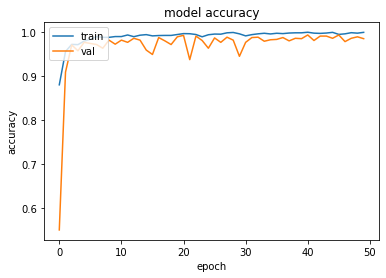

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Testing our model on the testing set .

In [19]:
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape

(900,)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

Plotting the confusion matrix of model's performance on test set.

[[447   1]
 [ 13 439]]


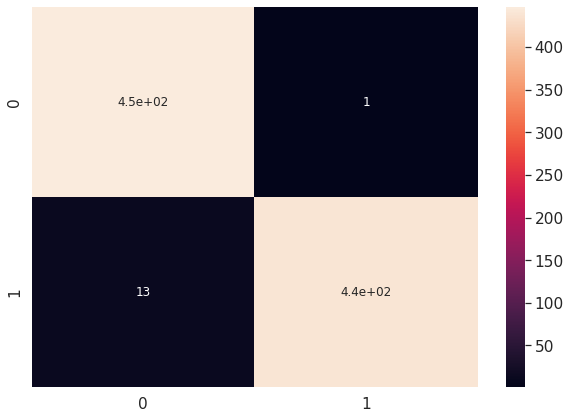

In [26]:
test_actual = np.argmax(test_labels,axis=1)

cm = confusion_matrix(test_actual,test_pred)
print(cm)
import seaborn as sn
import pandas  as pd
df_cm = pd.DataFrame(cm, range(2),
                  range(2))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})
plt.show()

Plotting Accuracy and F1 score of the model's performance.

In [27]:
print('Accuracy: %.3f' % accuracy_score(test_actual, test_pred))
print('F1 Score: %.3f' % f1_score(test_actual, test_pred))

Accuracy: 0.984
F1 Score: 0.984


Now we are creating a function to find ROI(Region of interest) using Selective search algorithm.

In [6]:
def find_regions(image):
    
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    boxes = []
    for (x,y,w,h) in rects:
        boxes.append([x,y,w,h])
    return boxes

We will load the scenes/images on which we have to detect ships.

In [2]:
scene_path = '/content/drive/MyDrive/ShipDetection/scenes/scenes'

def load_scenes():
    scenes = []
    dirfiles = os.listdir(scene_path)
    dirfiles = sorted(dirfiles)
    for file in dirfiles:
        print(os.path.join(scene_path, file))
        scene = cv2.imread(os.path.join(scene_path, file))
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        scenes.append(scene)
    return scenes

In [3]:
scenes = load_scenes()

/content/drive/MyDrive/ShipDetection/scenes/scenes/lb_2.png
/content/drive/MyDrive/ShipDetection/scenes/scenes/lb_3.png
/content/drive/MyDrive/ShipDetection/scenes/scenes/sfbay_1.png
/content/drive/MyDrive/ShipDetection/scenes/scenes/sfbay_4.png


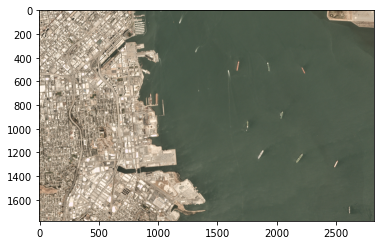

In [4]:
plt.imshow(scenes[2])

In [7]:
boxes = []
for scene in scenes:
    box_in_scene = find_regions(scene)
    boxes.append(box_in_scene)

Now we will pass the ROIs which we got into the model and bounding boxes are created on the images which are displayed below.

In [12]:
rois, locs = [], []
images = []
for i,scene in tqdm(enumerate(scenes)):
    
    (H, W) = scene.shape[:2]
    region, loc = [],[]
    for (x,y,w,h) in boxes[i]:

        roi = scene[y:y+h,x:x+w]
        roi = cv2.resize(roi, (80,80))

        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        pass
    
    preds = model.predict(np.array(rois,dtype=np.float32))
    preds = np.argmax(preds, axis=1)
    
    img = scene.copy()
    for (i,label) in enumerate(preds):

        if label == 1:
            (startX,startY,endX,endY) = locs[i]
            cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
        pass
    
    images.append(img)
    del rois[:]
    del locs[:]
    pass

4it [00:08,  2.06s/it]


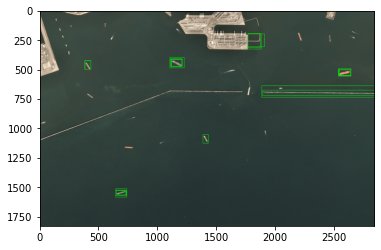

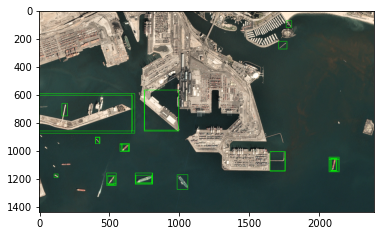

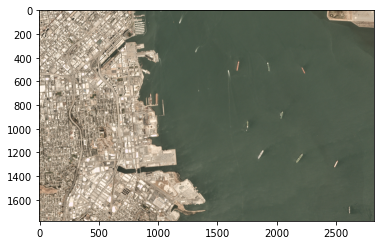

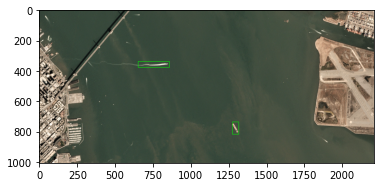

In [13]:
for image in images:
    
    plt.imshow(image)
    plt.show();